# Titanic: Machine Learning from Disaster

This notebook is an introduction to the [Kaggle titanic challenge](https://www.kaggle.com/c/titanic). The goal here is not to produce the best possible classifier, at least not yet, but to show how pyAgrum and Bayesian Networks can be used to easily and quickly explore and understand data.

To undestand this notebook, basic knowledge of Bayesian Networks is required. If you are looking for an introduction to pyAgrum, check [this notebook](http://www-desir.lip6.fr/~phw/aGrUM/docs/last/notebooks/01-tutorial.ipynb.html).

The notebook is split in four sections:
1. Pretreatment: where we mangle with the data.
2. Pre-learning: where we define our learning parameters.
3. Learning: where we learn a Bayesian Network.
4. Classification: where we use the Bayesian Network as a class ifier.

Before we start, some notes about aGrUM and pyAgrum. 

**aGrUM** is a C++ library designed for easily building applications using graphical models such as Bayesian networks, influence diagrams, decision trees or Markov decision processes. 

**pyAgrum** is a Python wrapper for the C++ aGrUM library. It provides a high-level interface to the part of aGrUM allowing to create, handle and make computations into Bayesian Networks. The module mainly is an application of the [SWIG](http://www.swig.org/) interface generator. Custom-written code is added to simplify and extend the aGrUM API.

Both projects are [open source](https://gitlab.com/agrumery/aGrUM/blob/master/LICENSE) and can be freely downloaded from [aGrUM's gitlab repository](https://gitlab.com/agrumery/aGrUM) or installed using [pip or anaconda](http://agrum.gitlab.io/pages/pyagrum.html).

If you have questions, remarks or suggestions, feel free to ask us on [info@agrum.org](mailto:info@agrum.org).

## Pretreatment
We will be using [pandas](http://pandas.pydata.org/) to setup the learning data to fit with pyAgrum requirements.

In [29]:
import pandas
import os

In [30]:
traindf=pandas.read_csv(os.path.join('res', 'titanic', 'train.csv'))

testdf=pandas.merge(pandas.read_csv(os.path.join('res', 'titanic', 'test.csv')),
                    pandas.read_csv(os.path.join('res', 'titanic', 'gender_submission.csv')),
                    on="PassengerId")

This merges both the test base and their respective classes, i.e. if a passagen has survived or not.

In [31]:
traindf.var()

PassengerId    66231.000000
Survived           0.236772
Pclass             0.699015
Age              211.019125
SibSp              1.216043
Parch              0.649728
Fare            2469.436846
dtype: float64

In [32]:
for k in traindf.keys():
    print('{0}: {1}'.format(k, len(traindf[k].unique())))

PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 89
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 148
Embarked: 4


Looking at the number of unique values for each variable necessary since Bayesian Networks are discrete models. We will want to reduce the domain size of some discrete varaibles (like age) and discretize continuous variables (like Fare).

For starters you can filter out variables with a large number of values. Choosing a large number will have an impact on performances, which boils down to how much CPU and RAM you have at your disposal. Here, we choose to filter out any variable with more than 10 different outcomes.

In [33]:
for k in traindf.keys():
    if len(traindf[k].unique())<=15:
        print(k)

Survived
Pclass
Sex
SibSp
Parch
Embarked


This leaves us with 6 variables, not much but still enough to learn a Bayesian Network. Will just add one more variable by reducing the cardinality of the Age variable.

In [34]:
import math

def forAge(row):
    if row['Age'] < 10:
        return '<10'
    elif math.isnan(row['Age']):
        return "nan"
    else:
        dec = str(int(row['Age']/10))
        return "{0}0's".format(dec)

decade=traindf.apply(forAge, axis=1)
print("Decade: {1}".format(k, len(decade.unique())))

Decade: 10


When pretreating data, you will want to wrap your changes inside a function, this will help you keep track of your changes and easily compare them.

In [81]:
import math
def pretreat(df):
    # create a df with discrete variables (len<10)
    lvd=[k for k in df.keys() if len(df[k].unique())<=15]
    res=df[lvd].copy()
    
    forAge = lambda row: int(row['Age']/10) if not math.isnan(row['Age']) else np.nan
    res['Decade']=df.apply(forAge, axis=1)
    
    res=res.dropna()    
    res['Decade']=res['Decade'].astype('int32')
    
    return res

In [82]:
ptraindf=pretreat(traindf)
ptestdf=pretreat(testdf)

We will need to save this intermediate learning database, since pyAgrum accepts only files as inputs.

In [83]:
ptraindf.to_csv(os.path.join('res', 'titanic', 'post_train.csv'), index=False)
ptestdf.to_csv(os.path.join('res', 'titanic', 'post_test.csv'), index=False)

## Pre-learning
Now we have two data files: `data/post_train.csv` and `data/post_test.csv`. The first one is our pretreated learning database, the second our pretreated test base.

Before learning a Bayesian Network, we first need to create a template. This is not mandatory, however it is sometimes usefull since not all varaibles values are present in the learning base (in this example the number of relatives).

If during the learning step, the algorithm encounters an unknown value it will raise an error. This would be an issue if we wanted to automitize our classifier but, we will directly use values working with the test and learning base. This is not ideal but the objective here it to explore the data fast, not thoroughly.

In [84]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

To help creating de the template Bayesian Network that we will use to learn our classifier, let us firt recall all the variables wa have at our disposal.

In [85]:
df = pandas.read_csv(os.path.join('res', 'titanic', 'post_train.csv'))
for k in df.keys():
    print("{} : {}".format(k, df[k].unique()))

Survived : [0 1]
Pclass : [3 1 2]
Sex : ['male' 'female']
SibSp : [1 0 3 4 2 5]
Parch : [0 1 2 5 3 4 6]
Embarked : ['S' 'C' 'Q']
Decade : [2 3 5 0 1 4 6 7 8]


From here, creating the BayesNet is straitforward: for each variable we either use the `RangeVariable` class or the `LabelizedVariable`.

The `RangeVariable` class creates a discrete random variable over a range. With the `LabelizedVariable` you will need to add each label ony by one. Note however that you can pass an argument to create as much labels starting from `0`.

In [86]:
template=gum.BayesNet()
template.add(gum.RangeVariable("Survived", "Survived",0,1))
template.add(gum.RangeVariable("Pclass", "Pclass",1,3))
template.add(gum.LabelizedVariable("Sex", "Sex",0).addLabel("female").addLabel("male"))
template.add(gum.RangeVariable("SibSp", "SibSp",0,8))
template.add(gum.RangeVariable("Parch", "Parch",0,9))
template.add(gum.LabelizedVariable("Embarked", "Embarked",0).addLabel('').addLabel('C').addLabel('Q').addLabel('S'))
template.add(gum.RangeVariable("Decade", "Calculated decade", 0,9))
             
gnb.showBN(template)

You can also let the learning algorithm create the BayesNet random variables. However please be aware that the algorithm will no be able to handle values absent from the learning database.

## Learning

We can now learn our first Bayesian Network. As you will see, this is really easy.

In [87]:
learner = gum.BNLearner(os.path.join('res', 'titanic', 'post_train.csv'), template)
bn = learner.learnBN()
bn

(gum::BayesNet<double>@0x555bcce70d00) BN{nodes: 7, arcs: 7, domainSize: 43200, parameters: 248, compression ratio: 99% }

In a notebook, a Bayesian Network will automatically be shown graphically, you can also use the helper function `gnb.showBN(bn)`.

## Exploring the data
Now that we have a BayesNet, we can start looking how the variables corelate with each other. pyAgum offer the perfect tool for that: the information graph.

In [88]:
gnb.showInformation(bn,{},size="20")

To read this graph, you must understand what the entropy of a variable means: the hightest the value the more uncertain the variable marginal probability distrubition is (maximum entropy beging the equiprobable law). The lowest the value is, the more /certain/ the law is.

A consequence of how entropy is calculated, is that entropy tends to get bigger if the random varaible has many modalities.

What the information graph tells us is that the `decade` variable has a hight entropy. Thus, we can conclude that the passengers `decade` is distributed between all of its modalities.

What it also tells us, it that high modality variables with low entropy, such as `Parch` or `SibSp`, are not evenly distributed.

Let us look at he variables marginal probability by using the `showInference()` function.

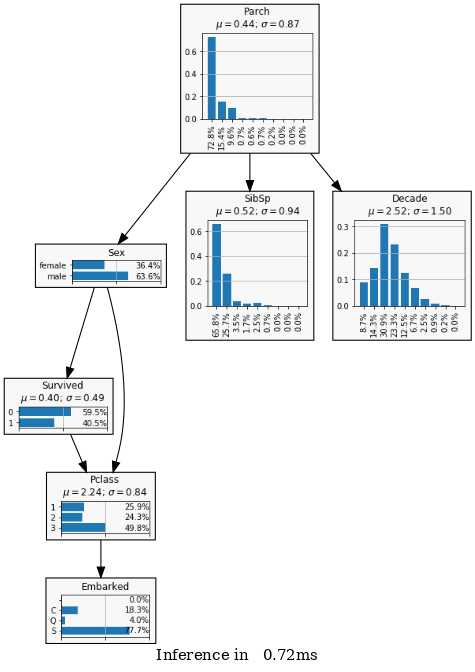

In [89]:
gnb.showInference(bn)

The `showInference()` is really usefull as it shows the marginal probability distribution for each random variable of a BayesNet.

We can now confirm what the entropy learned us: `Parch` and `SibSp` are unevenly distributed and `decade` is more evenly distributed.

Lets focus on the Kaggle challenge now, and look at the `Survived` variable. We show a single posterior using the `showPosterior()` function.

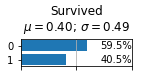

In [90]:
gnb.showPosterior(bn,evs={},target='Survived')

So more than 40% of the passenger in our learning database survived.

So how can we use this BayesNet as a classifier ? Given a set of evidence, we can infer an update posterio distribution of the target variable `Survived`.

Lets look at the odds of surviving as a man in his thirties.

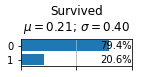

In [97]:
gnb.showPosterior(bn,evs={"Sex": "male", "Decade": 3},target='Survived')

And now the odds of an old lady to survive.

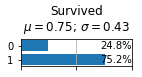

In [98]:
gnb.showPosterior(bn,evs={"Sex": "female", "Decade": 8},target='Survived')

Well, children and ladies first, that's right ?

One last information we will need is which variables are required to predict the `Survived` variable. To do, we will use the markov blanket of `Survived`.



In [99]:
gnb.sideBySide(bn, gum.MarkovBlanket(bn, 'Survived'), captions=["Learned Bayesian Network", "Markov blanket of 'Survived'"])

Learned Bayesian Network,Markov blanket of 'Survived'


The Markov Blanket of the `Survived` variable tells us that we only need to observe `Sex` and `Pclass` in order to predict `Survived`. Not really usefull here but on larger Bayesian Networks it can save you a lot of time and CPU.

So how to use this BayesNet we have learned as a classifier ? We simply infer the posterior the `Survive` variable given the set of evidence we are given, and if the passanger odds of survival are above some value he will be taged as a survivor.

To compute the best value given the BayesNet and our training database, we can use the `showROC()` function.

 res/titanic/post_train.csv : [ ############################################## ] 100%
 result in res/titanic/post_train.csv-ROC_unnamed-Survived-1.png


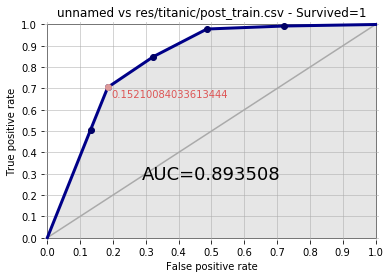

In [100]:
from pyAgrum.lib.bn2roc import showROC

showROC(bn, os.path.join('res', 'titanic', 'post_train.csv'),'Survived',"1",True,True)

In [101]:
vars = [ var for var in ptestdf.keys() if var != "Survived" ]
ie=gum.LazyPropagation(bn)
testdf=pandas.read_csv(os.path.join('res', 'titanic', 'post_test.csv'))

def init_belief():
    # Initialize evidence
    for var in vars:
        ie.addEvidence(var, 0)

def update_beliefs(row):
    # Update beliefs from a given row less the Survived variable
    for var in vars:
        label = str(row.to_dict()[var])
        idx = bn.variable(var).index(str(row.to_dict()[var]))
        ie.chgEvidence(var, idx)
    ie.makeInference()
    
def is_well_predicted(row):
    update_beliefs(row)
    marginal = ie.posterior('Survived')
    outcome = row.to_dict()['Survived']
    if outcome == 0: # Did not survived
        if marginal.toarray()[1] < 0.46576681:
            return "True Positive"
        else:
            return "False Negative"
    else: # Survived
        if marginal.toarray()[1] >= 0.46576681:
            return "True Negative"
        else:
            return "False Positive"

init_belief()
ie.addTarget('Survived')

result = testdf.apply(is_well_predicted, axis=1)

result.value_counts(True)

True Positive     0.617470
True Negative     0.231928
False Positive    0.150602
dtype: float64

In [102]:
positives = sum(result.map(lambda x: 1 if x.startswith("True") else 0 ))
total = result.count()
print("{0:.2f}% good predictions".format(positives/total*100))

84.94% good predictions
